In [68]:
########################################
# Import Data
########################################
import pandas as pd

#Import Data from whole exercise
df = pd.read_csv('data.csv', sep=',', header=0)
#clean dataframes
df = df.rename(columns=lambda x: x.strip())
df = df.dropna()
print('Whole exercise dataset:')
df

Whole exercise dataset:


,ID,GROUPE,MUSCLE,SWE_perc,SWE_raw,SWE_dist,ACTIVATION,LRELATIVE,LRELATIVE_pic,F_V,ForceRelative,ForceRelative_pic,ChargeInterne
0,1,NHE,SM,0.0,-0.1,0.00,0.341907,0.646984,0.996095,1.084533,0.263361,0.440011,0.256139
1,2,NHE,SM,6.0,2.0,0.18,0.602638,0.529459,0.841290,1.096524,0.355184,0.622870,0.368125
2,3,NHE,SM,0.0,-1.4,0.00,0.418067,0.683204,1.028167,1.089420,0.361932,0.722366,0.344897
3,4,NHE,SM,0.0,-7.6,0.00,0.397005,0.567855,0.935770,1.089609,0.277134,0.567802,0.270510
4,5,NHE,SM,0.0,-7.6,0.00,0.464852,0.718161,0.961237,1.064402,0.395749,0.636120,0.377784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,17,DL,BF,31.1,9.9,0.60,0.116118,1.288176,1.508788,1.094721,0.305250,0.571073,0.162181
59,18,DL,BF,0.0,-2.5,0.00,0.596198,1.130732,1.372417,1.079483,0.631827,0.824287,0.751614
60,19,DL,BF,17.6,6.4,0.66,0.340944,1.209678,1.434567,1.077420,0.430590,0.533246,0.449137
61,20,DL,BF,25.7,8.9,0.43,0.340485,1.302315,1.515599,1.078430,0.512893,0.774861,0.486235


Data normality test will be performed on ['SWE_perc', 'SWE_raw', 'SWE_dist', 'ACTIVATION', 'LRELATIVE', 'LRELATIVE_pic', 'F_V', 'ForceRelative', 'ForceRelative_pic', 'ChargeInterne']
      VARIABLE       TRANS. METHOD    RESULT    STATISTICS
          SWE_perc          Exp     FAIL     stat=0.798, p=0.000
          SWE_perc    Shift+Log    REFAIL    stat.=0.792, p=0.000
          SWE_perc  yeo-johnson    REFAIL    stat.=0.877, p=0.000
           SWE_raw          Exp     FAIL     stat=0.958, p=0.031
           SWE_raw    Shift+Log    REFAIL    stat.=nan, p=nan
           SWE_raw  yeo-johnson      OK      stat.=0.985, p=0.636
          SWE_dist          Exp     FAIL     stat=0.869, p=0.000
          SWE_dist    Shift+Log    REFAIL    stat.=0.850, p=0.000
          SWE_dist  yeo-johnson    REFAIL    stat.=0.870, p=0.000


C:\Users\doguet-v-3\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


        ACTIVATION          Exp     FAIL     stat=0.959, p=0.033
        ACTIVATION          Log      OK      stat.=0.969, p=0.113
        ACTIVATION      box-cox      OK      stat.=0.981, p=0.421
         LRELATIVE          Exp     FAIL     stat=0.928, p=0.001
         LRELATIVE          Log    REFAIL    stat.=0.913, p=0.000
         LRELATIVE      box-cox    REFAIL    stat.=0.929, p=0.001
     LRELATIVE_pic          Exp     FAIL     stat=0.916, p=0.000
     LRELATIVE_pic          Log    REFAIL    stat.=0.911, p=0.000
     LRELATIVE_pic      box-cox    REFAIL    stat.=0.915, p=0.000
               F_V          Exp      OK      stat=0.989, p=0.840
     ForceRelative          Exp     FAIL     stat=0.939, p=0.004
     ForceRelative          Log      OK      stat.=0.989, p=0.870
     ForceRelative      box-cox      OK      stat.=0.991, p=0.914
 ForceRelative_pic          Exp     FAIL     stat=0.930, p=0.002
 ForceRelative_pic          Log      OK      stat.=0.993, p=0.981
 ForceRelative_p

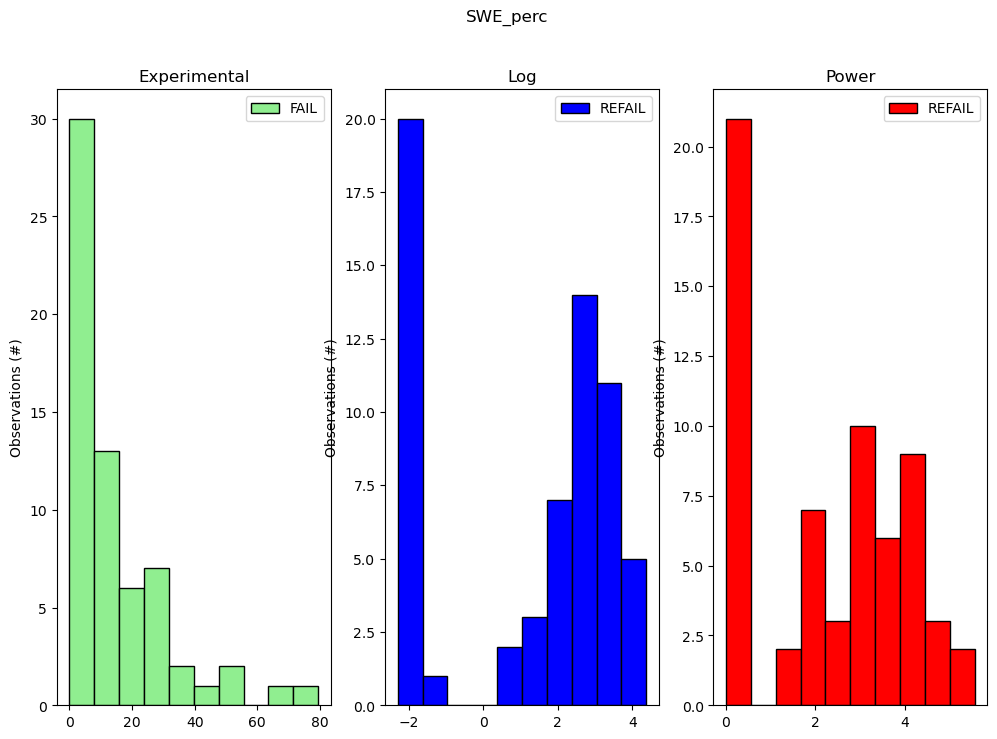

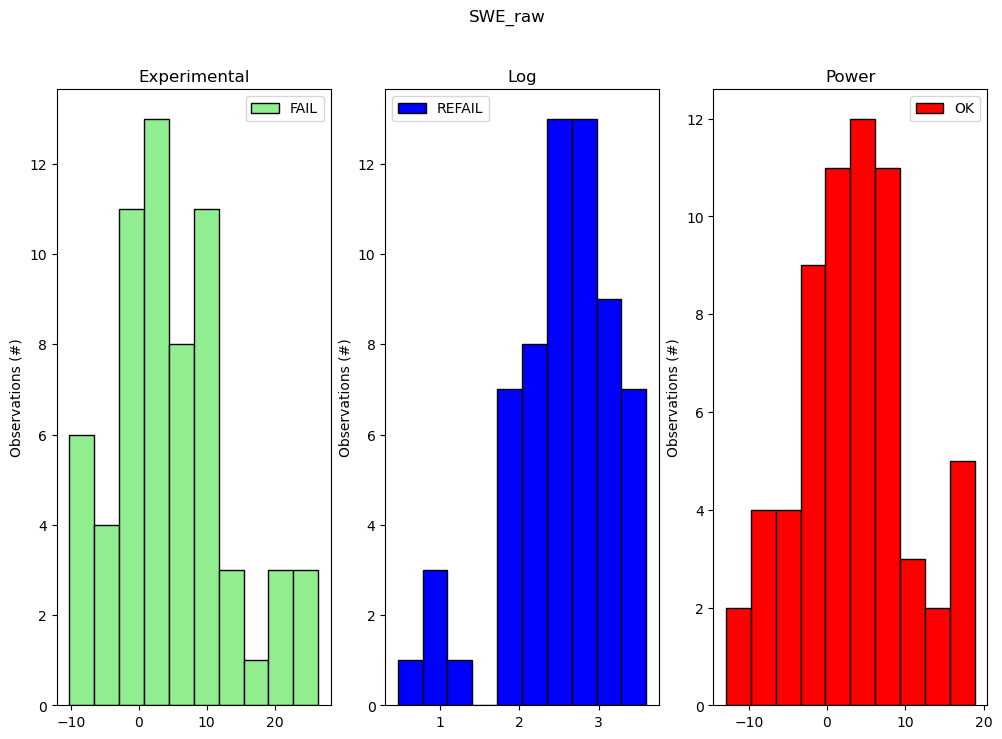

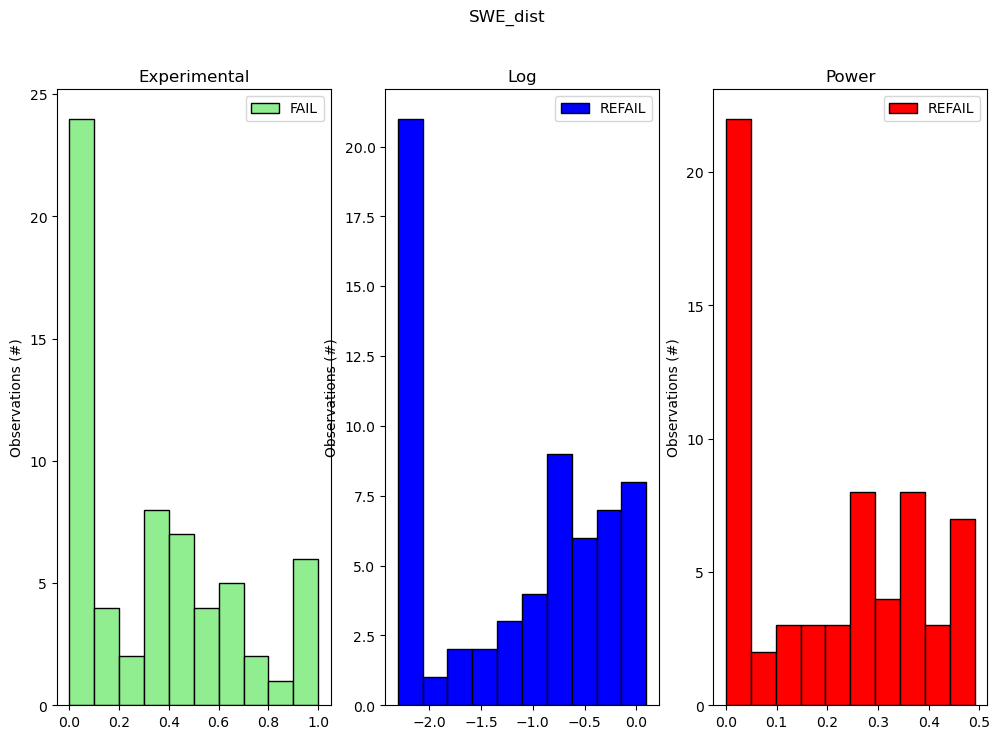

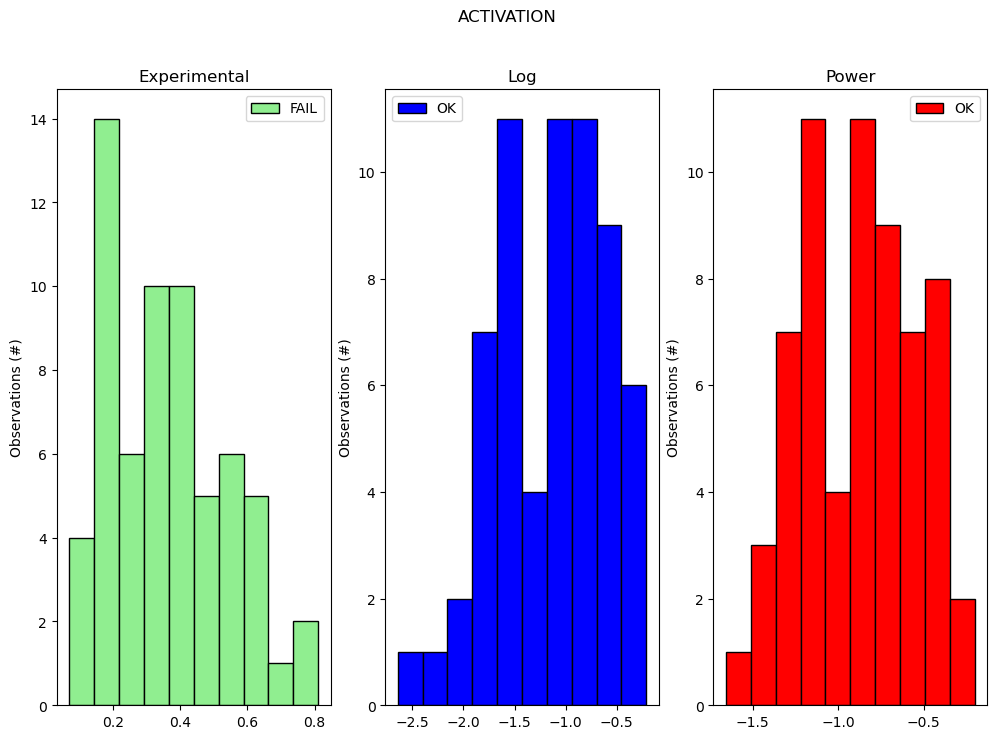

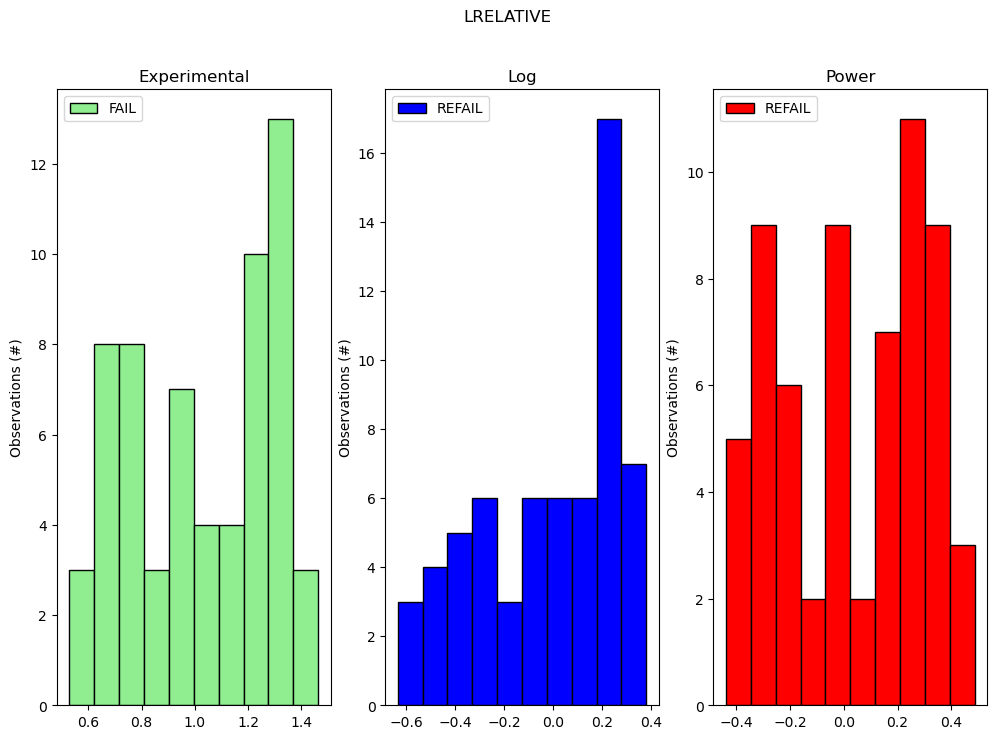

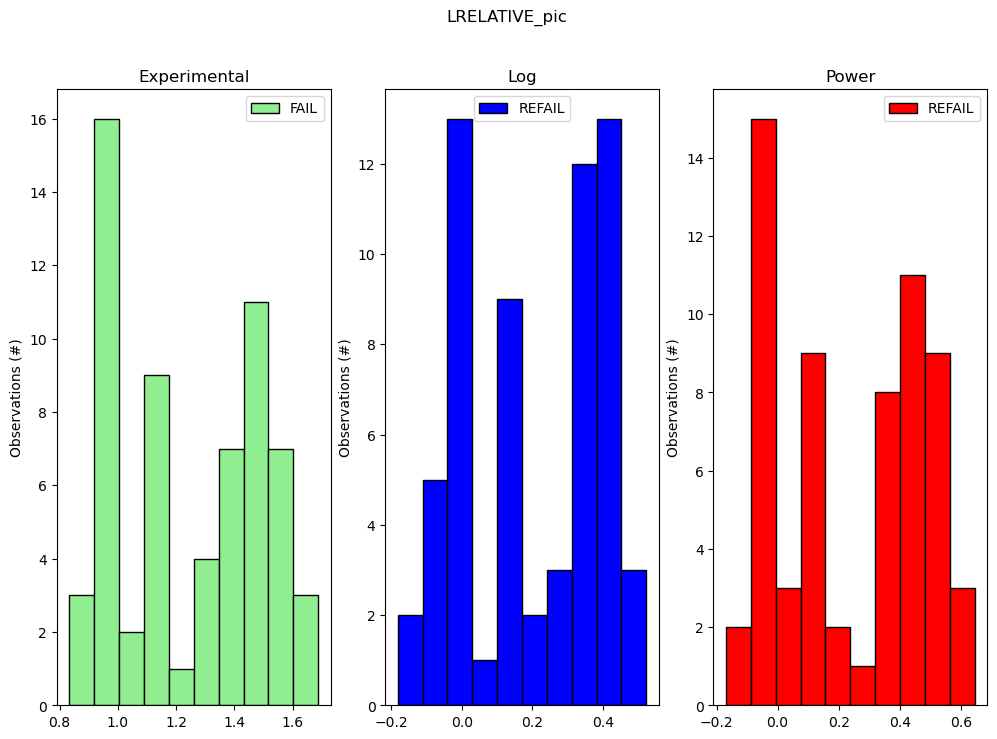

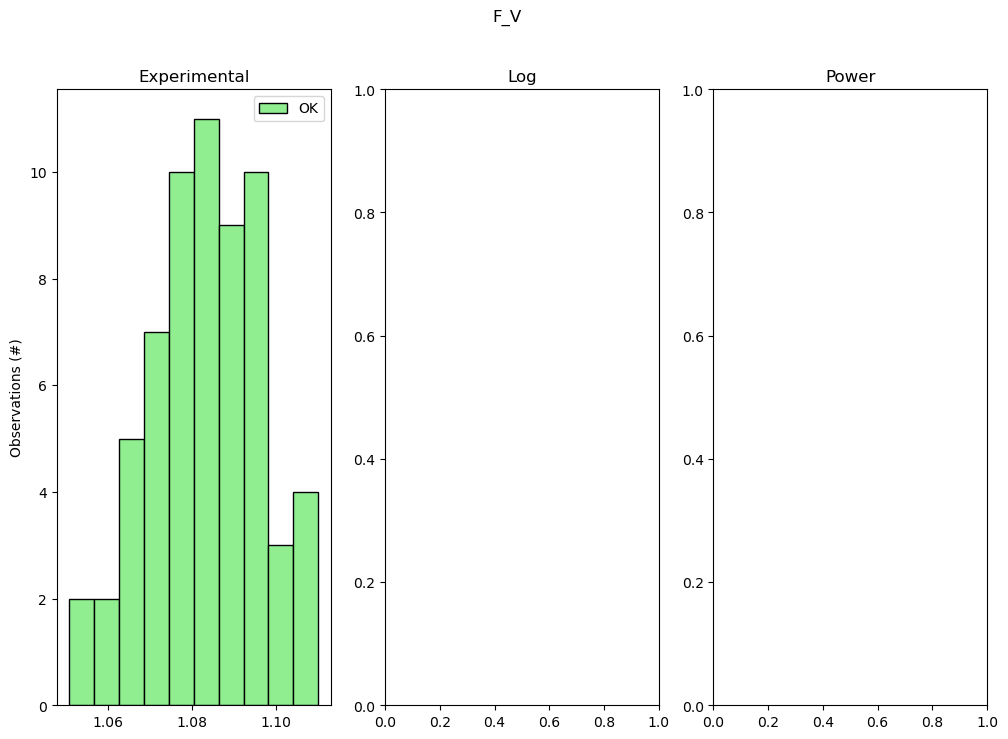

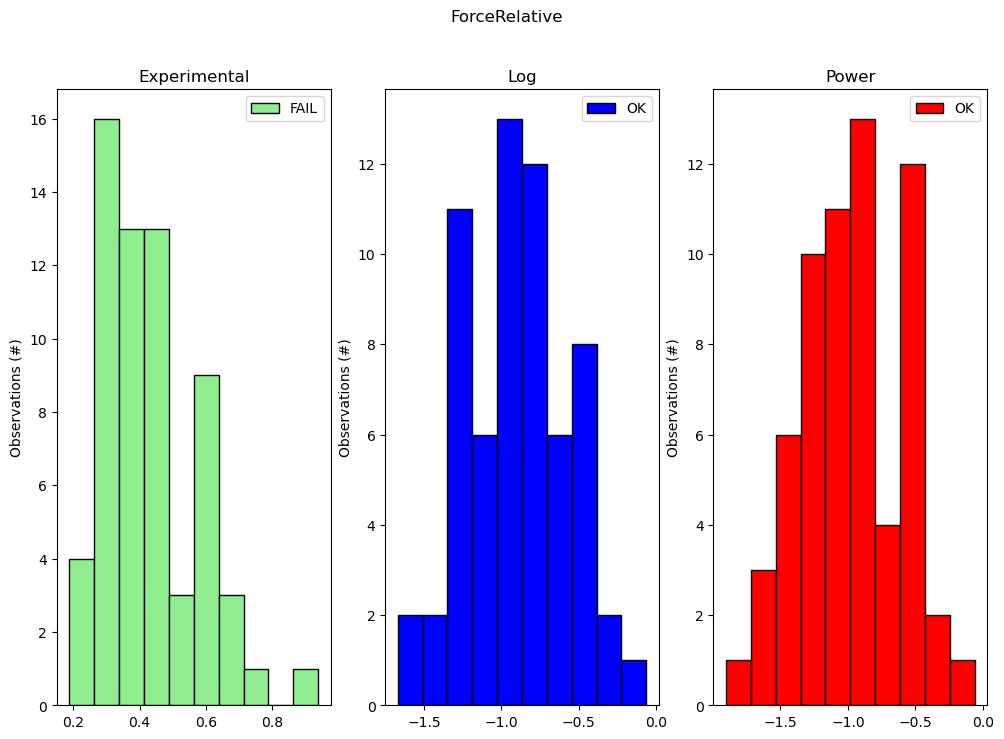

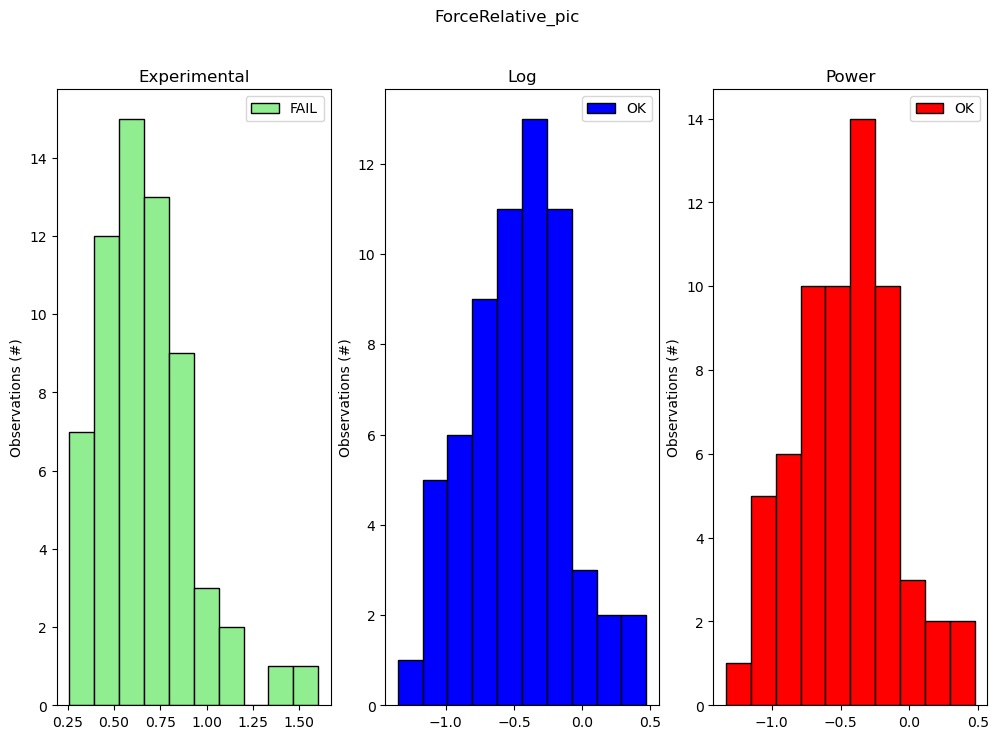

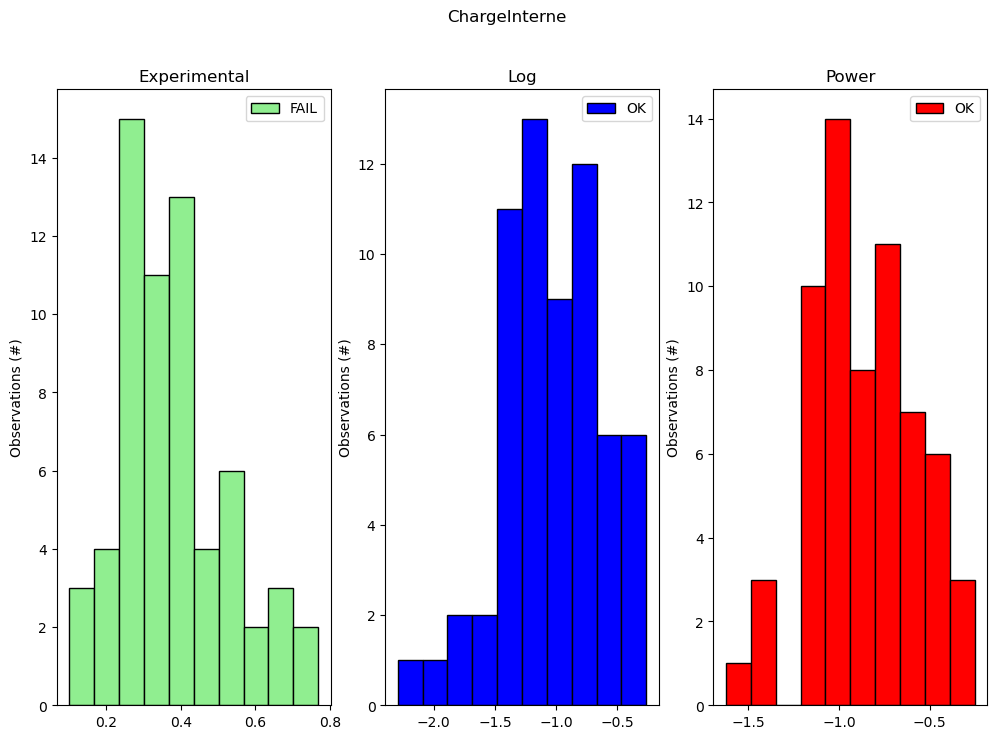

In [74]:
########################################
# Check Normality && Transform
########################################
import numpy as np
import matplotlib .pyplot as plt
from scipy.stats import shapiro, pearsonr, linregress
from sklearn import preprocessing
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

"""
Shapiro-Wilk test (doc. [1]) is used to test normality for all variables separately,
for the whole dataset at once (62 rows, mixing groups and muscles).
/!\ This should be checked since each subject is represented on 3 different rows. /!\
[1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

When normality test fails, data are transformed according to both log transform and power transform [2] and retesed.
[2] https://scikit-learn.org/stable/modules/preprocessing.html
"""

#Create independant copies of dataframes for data transforming purpose
dftrans = df.copy()
#create a list of column for which normality has to be tested
cols = df.drop(['ID', 'GROUPE', 'MUSCLE'], axis=1).columns.tolist()
print(f'Data normality test will be performed on {cols}')

#Print header for results
print(f'{"VARIABLE":^20} {"TRANS. METHOD":^12} {"RESULT":^12} STATISTICS')

#Enumerate all columns to test, perform Shapiro test and Plot data & transformed data if any.
for i, c in enumerate(cols):
    #prepare figure
    fig, axs = plt.subplots(1, 3)#use 3 columns to show experimental data, Log transformed and Power transformed data
    fig.suptitle(c)
    color = ['lightgreen', 'blue', 'red']
    #get the variable to test in initial dataframes
    y = df[c]
    #perform shapiro wilk test on whole exercise only
    stat, p = shapiro(y)
    #check result and process accordingly
    trans = 'Exp'
    if p > .05:
        norm = "OK"
        #show results
        print(f'{c:>18} {trans:>12} {norm:^12} stat={stat:.3f}, p={p:.3f}')
        line = f'{norm}'
        #define output variable identical to input
        yp = y
    else:
        norm = "FAIL"
        #show results
        print(f'{c:>18} {trans:>12} {norm:^12} stat={stat:.3f}, p={p:.3f}')
        line = f'{norm}'
        #then transform data using different ways
        k = 1;
        while True:
            if k > 2:
                break
            if k == 1:
                #make sure to handle only positive values since log of negative fails
                if np.any(y <= 0):
                    #if so, first shift all values to a constant value so that all data are >= 0 and log them
                    trans = 'Shift+Log'
                    yp = np.array(np.log(y + abs(np.min(y) + .1)))      #shifted log transform
                else:
                    trans = 'Log'
                    yp = np.array(np.log(y))      #only log transform
                #replace inf value (if any zero value)
                yp[np.where(np.isinf(yp))] = 0
            elif k == 2:
                try:
                    # Parametric Power Transform that only accept positive values
                    trans = 'box-cox'
                    pt = preprocessing.PowerTransformer(method=trans, standardize=False)
                    yp = pt.fit_transform(np.array(y).reshape(-1, 1))
                except:
                    # Parametric Power Transform
                    trans = 'yeo-johnson'
                    pt = preprocessing.PowerTransformer(method=trans, standardize=False)
                    yp = pt.fit_transform(np.array(y).reshape(-1, 1))
                #reshape
                yp = yp.reshape(1, -1)[0]
            #Retest normality with tranformed data
            stat, p = shapiro(yp)
            #show result
            print(f'{c:>18} {trans:>12} {"OK" if p > 0.05 else "REFAIL":^12} stat.={stat:.3f}, p={p:.3f}')
            line2 = f'{"OK" if p > 0.05 else "REFAIL"}'
            #show modifyed data
            axs[k].hist(yp,
                        bins=10,
                        color=color[k],
                        ec='black',
                        label=line2)
            axs[k].set_ylabel('Observations (#)')
            axs[k].legend(facecolor='white')
            #increment
            k += 1
    #modify in transformad dataframes
    dftrans[c] = pd.Series(yp)
    #plot raw data
    axs[0].hist(y,
                bins=10,
                color=color[0],
                ec='black',
                label=line)
    axs[0].set_ylabel('Observations (#)')
    axs[0].legend(facecolor='white')
    axs[0].set_title('Experimental')
    axs[2].set_title('Power')
    axs[1].set_title('Log')


In [77]:
"""
As a result, Experimental data for F-V was the only variable normally distributed at first.

For the remaining variables, power data transformation was used since this method showed better results than log transform.

For SWE variables, only SWE_raw (absolute diff between PRE & POST tests) passed the test and it was kept as dependent variable for regressions.
Both SWE_perc (absolute changes PRE-POST) and SWE_dist (distribution of SWE among hamstring) were discarded.

/!\ Both LRELATIVE nd LRELATIVE_pic failed the test. Therefore, performing linear regresion with these variables might introduce a bias.
"""
dftrans = dftrans.drop(['SWE_perc', 'SWE_dist'], axis=1)
print('Dataframe to work with after data transform step')
dftrans

Dataframe to work with after data transform step


,ID,GROUPE,MUSCLE,SWE_raw,ACTIVATION,LRELATIVE,LRELATIVE_pic,F_V,ForceRelative,ForceRelative_pic,ChargeInterne
0,1,NHE,SM,-0.100684,-0.878559,-0.336165,-0.003907,1.084533,-1.478666,-0.813657,-1.102581
1,2,NHE,SM,1.827406,-0.459980,-0.439358,-0.161726,1.096524,-1.120714,-0.470984,-0.854465
2,3,NHE,SM,-1.503155,-0.740407,-0.303383,0.028079,1.089420,-1.098727,-0.324075,-0.901214
3,4,NHE,SM,-9.328965,-0.776950,-0.406205,-0.064704,1.089609,-1.416511,-0.562507,-1.067066
4,5,NHE,SM,-9.328965,-0.663097,-0.271338,-0.038934,1.064402,-0.995234,-0.450147,-0.835614
...,...,...,...,...,...,...,...,...,...,...,...
58,17,DL,BF,7.899572,-1.461882,0.297672,0.484567,1.094721,-1.299997,-0.556833,-1.376642
59,18,DL,BF,-2.783162,-0.468795,0.132756,0.358873,1.079483,-0.475488,-0.192831,-0.272797
60,19,DL,BF,5.334027,-0.880420,0.214792,0.416488,1.077420,-0.898753,-0.624485,-0.705580
61,20,DL,BF,7.180320,-0.881310,0.312734,0.490777,1.078430,-0.702632,-0.254364,-0.643459


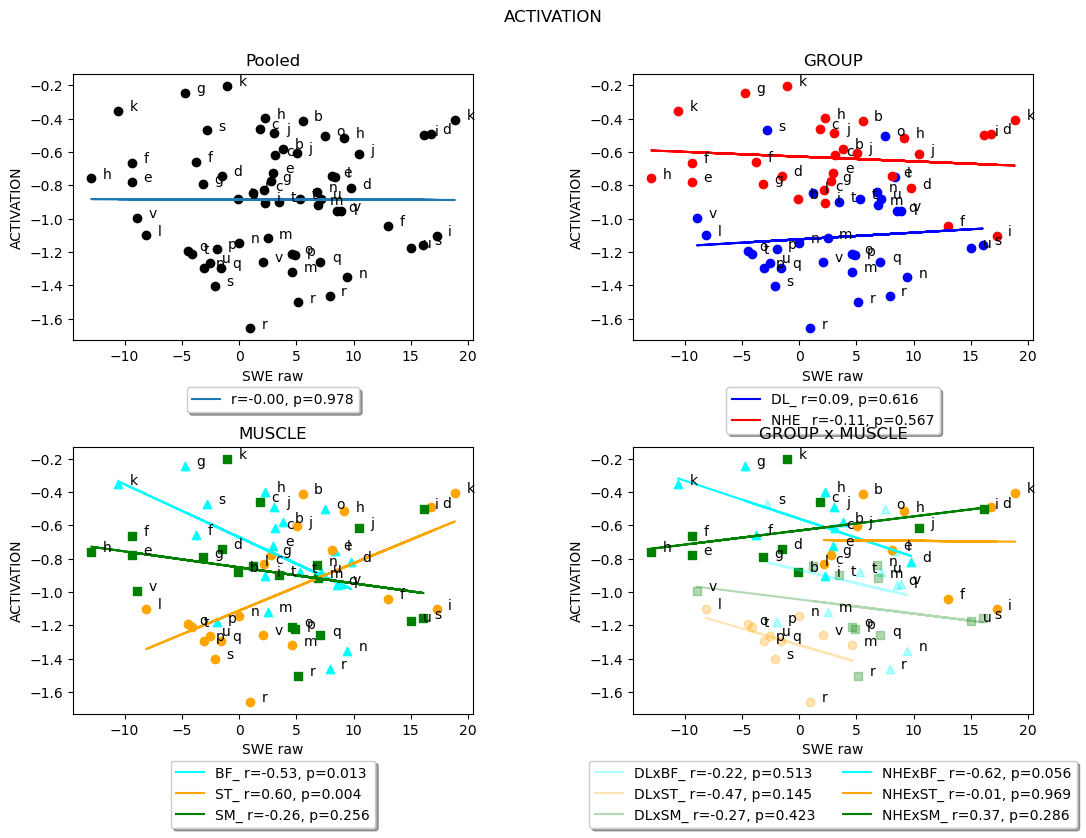

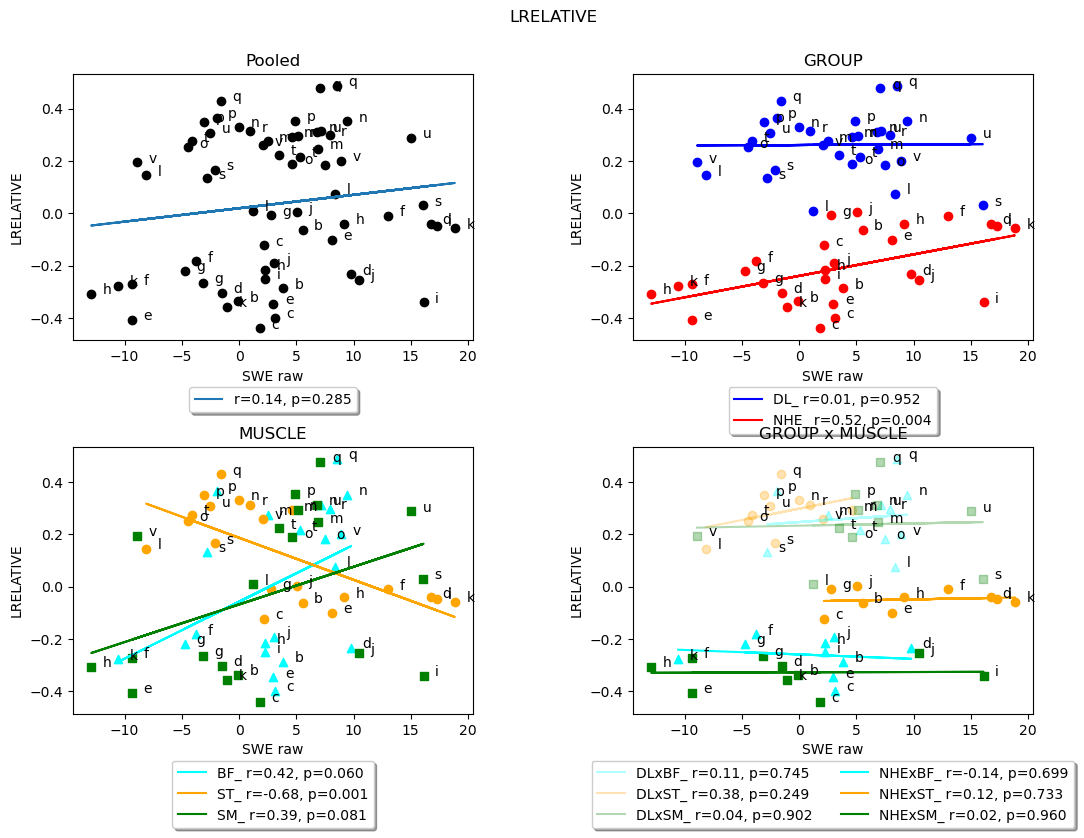

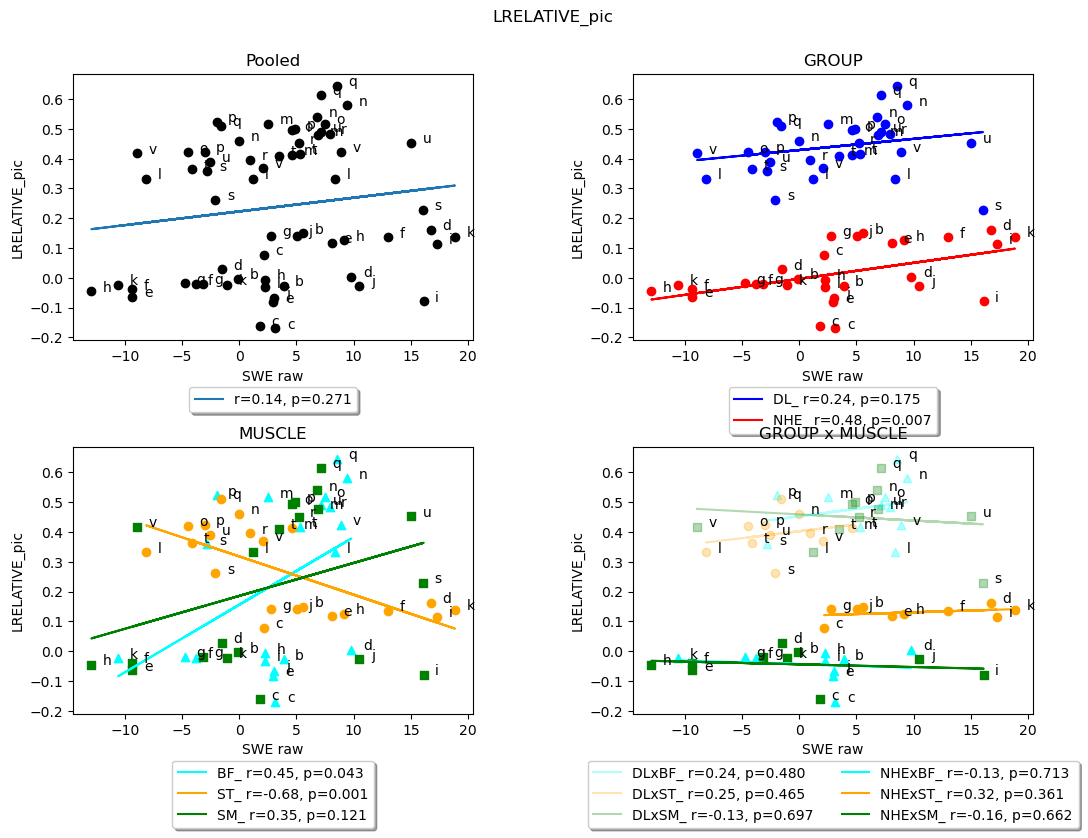

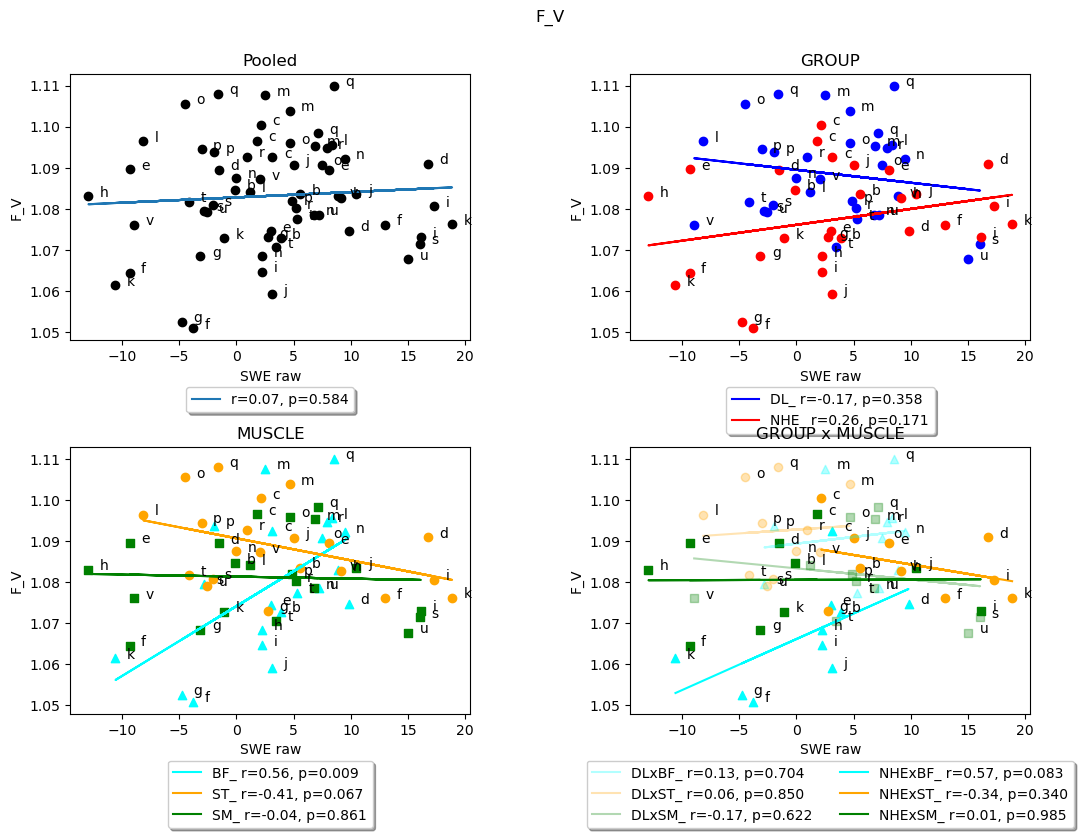

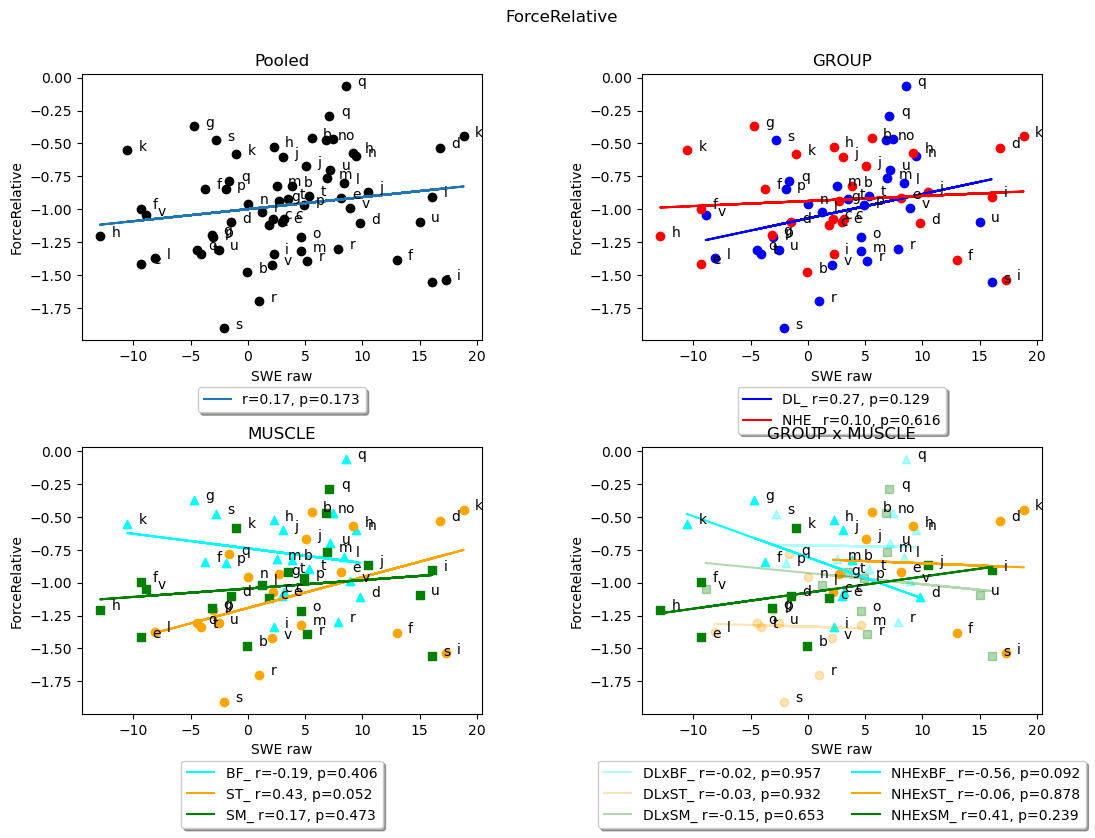

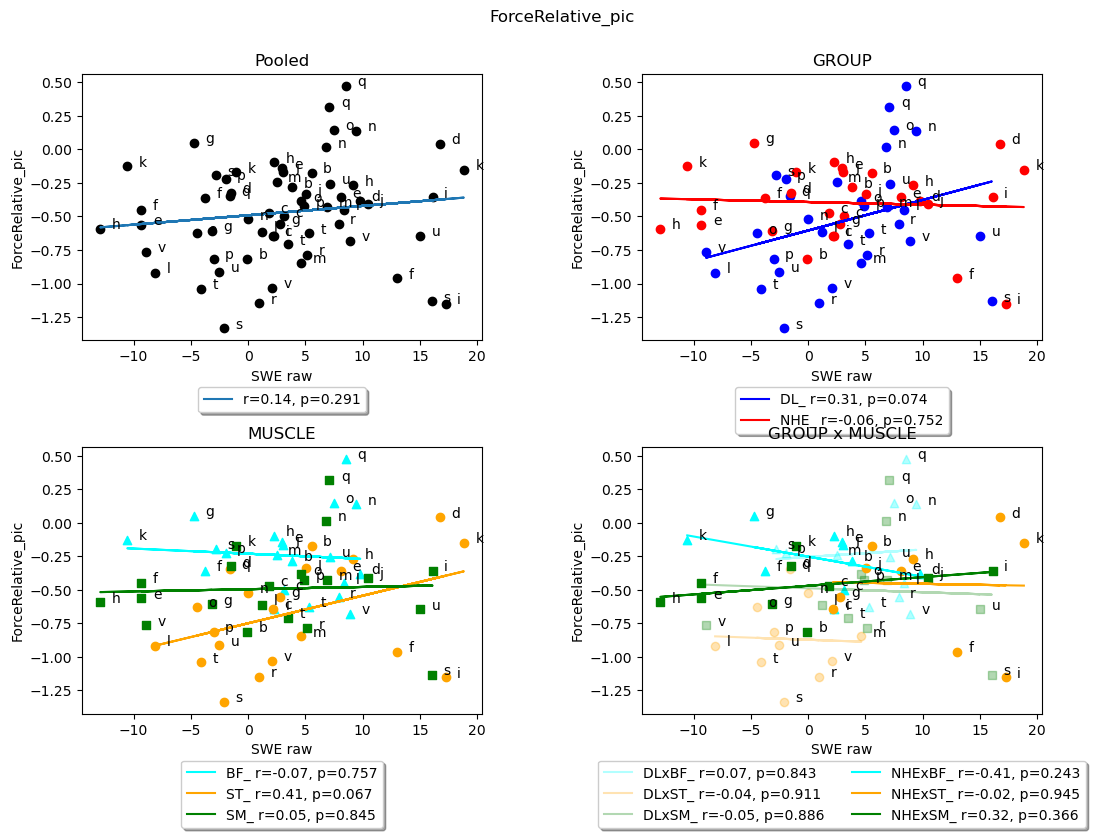

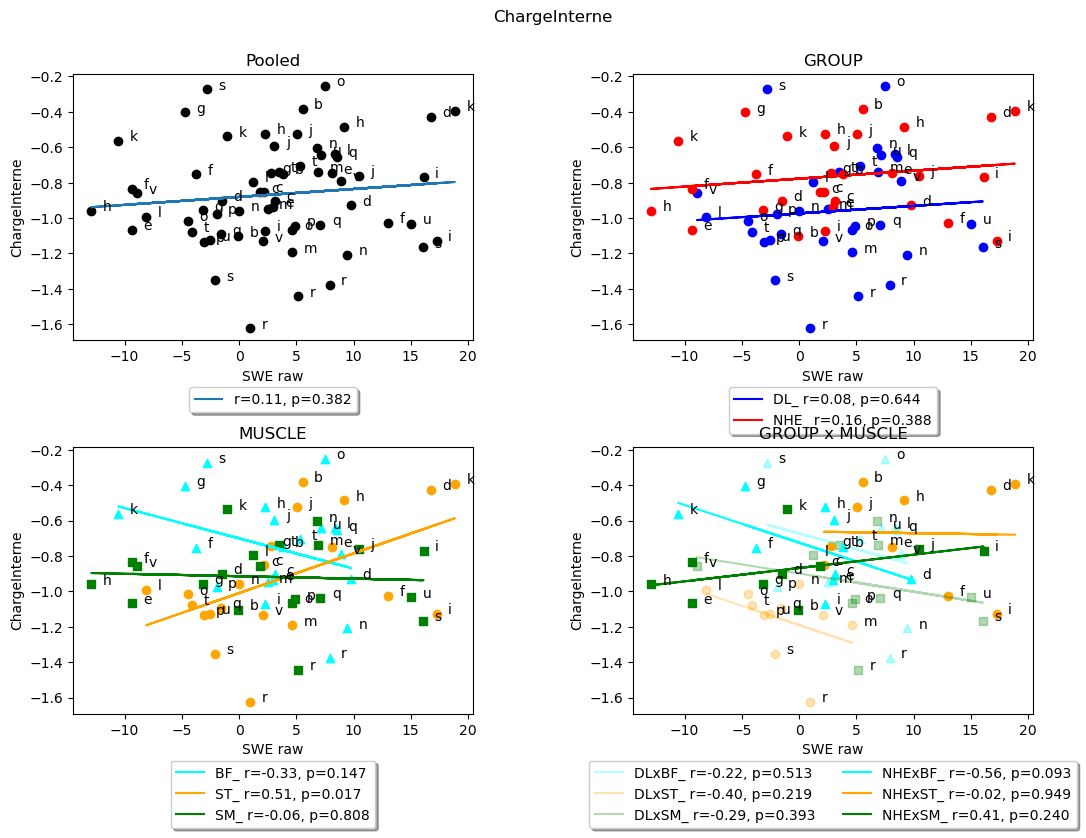

In [85]:
#####################################
# Separate linear regression
#####################################

"""
Separate linear regression are performed with the only SWE variable that was normally distributed :
SWE_raw (absolute diff between PRE & POST tests)
"""
#get a working dataframe
base_df = dftrans.copy()
#Add some variable dor visualization purpose
base_df['Marker'] = df['MUSCLE'].replace('SM', 's').replace('ST', 'o').replace('BF', '^')
base_df['Color'] = df['GROUPE'].replace('NHE', 'red').replace('DL', 'blue')

col = 0
row = 0
#define independent variable
indep = 'SWE_raw'
#get colnames of dependent variables
cols = list(base_df.drop(['ID', 'GROUPE', 'MUSCLE', 'Marker', 'Color', indep], axis=1).columns)
#loop them
for c in cols:
    #create a figure at each column
    fig, axs = plt.subplots(2, 2) #all, group, muscle, interact
    fig.suptitle(c)
    #proceed for all data
    x = np.array(base_df[indep])
    y = np.array(base_df[c])
    #all in one for linear regression
    result = linregress(x, y)
    #draw
    line = f'r={result.rvalue:.2f}, p={result.pvalue:.3f}'
    axs[0, 0].scatter(x, y, marker='o', c='#000')
    axs[0, 0].plot(x, result.intercept + result.slope * x, label=line)
    axs[0, 0].set_title('Pooled')
    axs[0, 0].set_ylabel(c)
    axs[0, 0].set_xlabel('SWE raw')
    axs[0, 0].legend(facecolor='white', loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=1)
    for i, txt in enumerate(base_df['ID']):
        axs[0, 0].annotate(chr(int(txt) + 97), (x[i]+1, y[i]))
    #Then proceed for sub groups (level 2)
    for gr, sub in base_df.groupby('Color'):
        x = np.array(sub[indep])
        y = np.array(sub[c])
        result = linregress(x, y)
        #draw
        line = f'{sub.GROUPE.iloc[0]}_ r={result.rvalue:.2f}, p={result.pvalue:.3f}'
        axs[0, 1].scatter(x, y, marker='o', c=gr)
        axs[0, 1].plot(x, result.intercept + result.slope * x, color=gr, label=line)
        axs[0, 1].set_title('GROUP')
        axs[0, 1].set_ylabel(c)
        axs[0, 1].set_xlabel('SWE raw')
        axs[0, 1].legend(facecolor='white', loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=1)
        for i, txt in enumerate(sub['ID']):
            axs[0, 1].annotate(chr(int(txt) + 97), (x[i]+1, y[i]))
        #also for sub muscles (level 2)
        for mu, sub2 in sub.groupby('Marker'):
            x = np.array(sub2[indep])
            y = np.array(sub2[c])
            result = linregress(x, y)
            #define a color based on marker
            if mu == 's': color = 'green'
            elif mu == 'o': color = 'orange'
            elif mu == '^': color = 'cyan'
            if gr == 'red':
                alpha=1
            elif  gr == 'blue':
                alpha= .3
            #draw
            line = f'{sub2.GROUPE.iloc[0]}x{sub2.MUSCLE.iloc[0]}_ r={result.rvalue:.2f}, p={result.pvalue:.3f}'
            axs[1, 1].scatter(x, y, marker=mu, c=color, alpha=alpha)
            axs[1, 1].plot(x, result.intercept + result.slope * x, color=color, alpha=alpha, label=line)
            axs[1, 1].set_title('GROUP x MUSCLE')
            axs[1, 1].set_ylabel(c)
            axs[1, 1].set_xlabel('SWE raw')
            axs[1, 1].legend(facecolor='white', loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
            for i, txt in enumerate(sub2['ID']):
                axs[1, 1].annotate(chr(int(txt) + 97), (x[i]+1, y[i]))
    #now for sub muscles (level 2)
    for mu, sub in base_df.groupby('Marker'):
        x = np.array(sub[indep])
        y = np.array(sub[c])
        result = linregress(x, y)
        #define a color based on marker
        if mu == 's': color = 'green'
        elif mu == 'o': color = 'orange'
        elif mu == '^': color = 'cyan'
        #draw
        line = f'{sub.MUSCLE.iloc[0]}_ r={result.rvalue:.2f}, p={result.pvalue:.3f}'
        axs[1, 0].scatter(x, y, marker=mu, c=color)
        axs[1, 0].plot(x, result.intercept + result.slope * x, color=color, label=line)
        axs[1, 0].set_title('MUSCLE')
        axs[1, 0].set_ylabel(c)
        axs[1, 0].set_xlabel('SWE raw')
        axs[1, 0].legend(facecolor='white', loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=1)
        for i, txt in enumerate(sub['ID']):
            axs[1, 0].annotate(chr(int(txt) + 97), (x[i]+1, y[i]))
    
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()

